In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
#
import torch
import torch.nn as nn
import torch.nn.functional as f
#
import mnist1d
from mnist1d.data import get_dataset_args, get_dataset
from mnist1d.utils import plot_signals
from solvers import get_optimizer
from models import *

In [2]:
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

Using: cuda


## Load Data

In [3]:
args = get_dataset_args()
data = get_dataset(args, path='./mnist1d_data.pkl', download=True) # This is the default setting

Saving to ./mnist1d_data.pkl
Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...


In [4]:
x = data["x"]
t = data["t"]
y = data["y"]

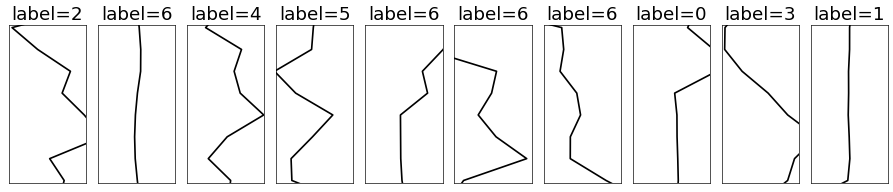

In [5]:
fig = plot_signals(x, t, labels=y, args=args, ratio=2.2, do_transform=True)

## Solvers

In [6]:
solvers = [
    {"optimizer": "sgd",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
         "momentum": 0.9
     }},
    {"optimizer": "adam",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "yogi",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "shampoo",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
         "momentum": 0.9
     }},
    {"optimizer": "swats",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "sgdw",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
         "momentum": 0.9
     }},
    {"optimizer": "sgdp",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
         "momentum": 0.9
     }},
    {"optimizer": "rangerva",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "rangerqh",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "ranger",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "radam",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "qhm",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
         "momentum": 0.9
     }},
    {"optimizer": "qhadam",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "pid",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
         "momentum": 0.9
     }},
    {"optimizer": "novograd",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "lamb",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "diffgrad",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "aggmo",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "adamp",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "adabound",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "adabelief",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "accsgd",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
]

## Train

In [7]:
batch_size = 100
total_steps = 8000
print_every = 1000
eval_every = 200
device = DEVICE
seed = 42

In [9]:
def accuracy(model, inputs, targets):
    preds = model(inputs).argmax(-1).cpu().numpy()
    targets = targets.cpu().numpy().astype(np.float32)
    return 100*sum(preds==targets)/len(targets)

def train_model(dataset, model, optimizer):
    criterion = nn.CrossEntropyLoss()

    results = {'train_losses':[], 'test_losses':[],'train_acc':[],'test_acc':[]}
    t0 = time.time()
    for step in range(total_steps+1):
        bix = (step*batch_size)%len(x_train) # batch index
        x, y = x_train[bix:bix+batch_size], y_train[bix:bix+batch_size]
      
        loss = criterion(model(x), y)
        loss.backward() ; optimizer.step() ; optimizer.zero_grad()

        if eval_every > 0 and step % eval_every == 0: # evaluate the model
            with torch.no_grad():
                test_loss = criterion(model(x_test), y_test)
                train_loss = criterion(model(x_train), y_train)
                results['train_losses'].append(train_loss.item())
                results['test_losses'].append(test_loss.item())
                results['train_acc'].append(accuracy(model, x_train, y_train))
                results['test_acc'].append(accuracy(model, x_test, y_test))

        if step > 0 and step % print_every == 0: # print out training progress
            t1 = time.time()
            print("step {}, dt {:.2f}s, train_loss {:.3e}, test_loss {:.3e}, train_acc {:.1f}, test_acc {:.1f}"
                  .format(step, t1-t0, loss.item(), results['test_losses'][-1], \
                  results['train_acc'][-1], results['test_acc'][-1]))
            t0 = t1
    return results

In [10]:
criterion = nn.CrossEntropyLoss()

x_train, x_test = torch.Tensor(data['x']), torch.Tensor(data['x_test'])
y_train, y_test = torch.LongTensor(data['y']), torch.LongTensor(data['y_test'])
#
x_train, x_test, y_train, y_test = [v.to(DEVICE) for v in [x_train, x_test, y_train, y_test]]


In [11]:
solvers

[{'optimizer': 'sgd',
  'optimizer_args': {'lr': 0.01, 'weight_decay': 0, 'momentum': 0.9}},
 {'optimizer': 'adam', 'optimizer_args': {'lr': 0.01, 'weight_decay': 0}},
 {'optimizer': 'yogi', 'optimizer_args': {'lr': 0.01, 'weight_decay': 0}},
 {'optimizer': 'shampoo',
  'optimizer_args': {'lr': 0.01, 'weight_decay': 0, 'momentum': 0.9}},
 {'optimizer': 'swats', 'optimizer_args': {'lr': 0.01, 'weight_decay': 0}},
 {'optimizer': 'sgdw',
  'optimizer_args': {'lr': 0.01, 'weight_decay': 0, 'momentum': 0.9}},
 {'optimizer': 'sgdp',
  'optimizer_args': {'lr': 0.01, 'weight_decay': 0, 'momentum': 0.9}},
 {'optimizer': 'rangerva', 'optimizer_args': {'lr': 0.01, 'weight_decay': 0}},
 {'optimizer': 'rangerqh', 'optimizer_args': {'lr': 0.01, 'weight_decay': 0}},
 {'optimizer': 'ranger', 'optimizer_args': {'lr': 0.01, 'weight_decay': 0}},
 {'optimizer': 'radam', 'optimizer_args': {'lr': 0.01, 'weight_decay': 0}},
 {'optimizer': 'qhm',
  'optimizer_args': {'lr': 0.01, 'weight_decay': 0, 'momentum':

In [12]:
x_train.shape

torch.Size([4000, 40])

## Train CNN

In [13]:
all_results = {}
for params in solvers:
    print(params["optimizer"])
    model = ConvBase(output_size=10)
    model = model.to(DEVICE)
    optimizer = get_optimizer(params["optimizer"], model, params["optimizer_args"])
    result = train_model(data, model, optimizer)
    all_results[params["optimizer"]] = result

sgd
Initialized ConvBase model with 5210 parameters
step 1000, dt 4.25s, train_loss 1.023e+00, test_loss 9.847e-01, train_acc 64.7, test_acc 59.4
step 2000, dt 4.02s, train_loss 3.668e-01, test_loss 5.398e-01, train_acc 86.6, test_acc 81.6
step 3000, dt 3.46s, train_loss 1.535e-01, test_loss 4.901e-01, train_acc 92.0, test_acc 84.0
step 4000, dt 4.09s, train_loss 1.991e-01, test_loss 6.052e-01, train_acc 90.7, test_acc 84.9
step 5000, dt 3.90s, train_loss 4.385e-02, test_loss 5.159e-01, train_acc 97.0, test_acc 87.4
step 6000, dt 3.85s, train_loss 1.934e-02, test_loss 4.728e-01, train_acc 99.7, test_acc 90.4
step 7000, dt 3.85s, train_loss 1.941e-02, test_loss 4.982e-01, train_acc 99.9, test_acc 90.4
step 8000, dt 4.00s, train_loss 2.790e-03, test_loss 5.272e-01, train_acc 100.0, test_acc 90.3
adam
Initialized ConvBase model with 5210 parameters
step 1000, dt 4.21s, train_loss 1.513e-01, test_loss 4.028e-01, train_acc 94.3, test_acc 88.8
step 2000, dt 4.18s, train_loss 1.205e-02, test_

/home/matthias/anaconda3/envs/pt2/lib/python3.6/site-packages/pytorch_ranger/ranger913A.py:132: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729021865/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


step 1000, dt 4.27s, train_loss 7.131e-01, test_loss 7.593e-01, train_acc 74.5, test_acc 71.6
step 2000, dt 4.28s, train_loss 1.463e-01, test_loss 4.358e-01, train_acc 93.3, test_acc 85.2
step 3000, dt 4.29s, train_loss 4.935e-02, test_loss 4.148e-01, train_acc 98.7, test_acc 88.4
step 4000, dt 4.32s, train_loss 2.336e-02, test_loss 5.401e-01, train_acc 98.2, test_acc 87.2
step 5000, dt 4.29s, train_loss 5.790e-03, test_loss 5.215e-01, train_acc 100.0, test_acc 89.6
step 6000, dt 4.28s, train_loss 3.780e-03, test_loss 5.496e-01, train_acc 100.0, test_acc 89.5
step 7000, dt 4.29s, train_loss 2.223e-03, test_loss 5.739e-01, train_acc 100.0, test_acc 89.5
step 8000, dt 4.33s, train_loss 1.631e-03, test_loss 5.950e-01, train_acc 100.0, test_acc 89.6
rangerqh
Initialized ConvBase model with 5210 parameters
step 1000, dt 4.23s, train_loss 1.198e-01, test_loss 4.643e-01, train_acc 93.5, test_acc 86.0
step 2000, dt 4.11s, train_loss 2.994e-02, test_loss 4.338e-01, train_acc 99.1, test_acc 89.3

In [14]:
with open("cnn_results.pkl", "wb") as file:
    pickle.dump(all_results, file)

with open("cnn_results.pkl", "rb") as file:
    results = pickle.load(file)

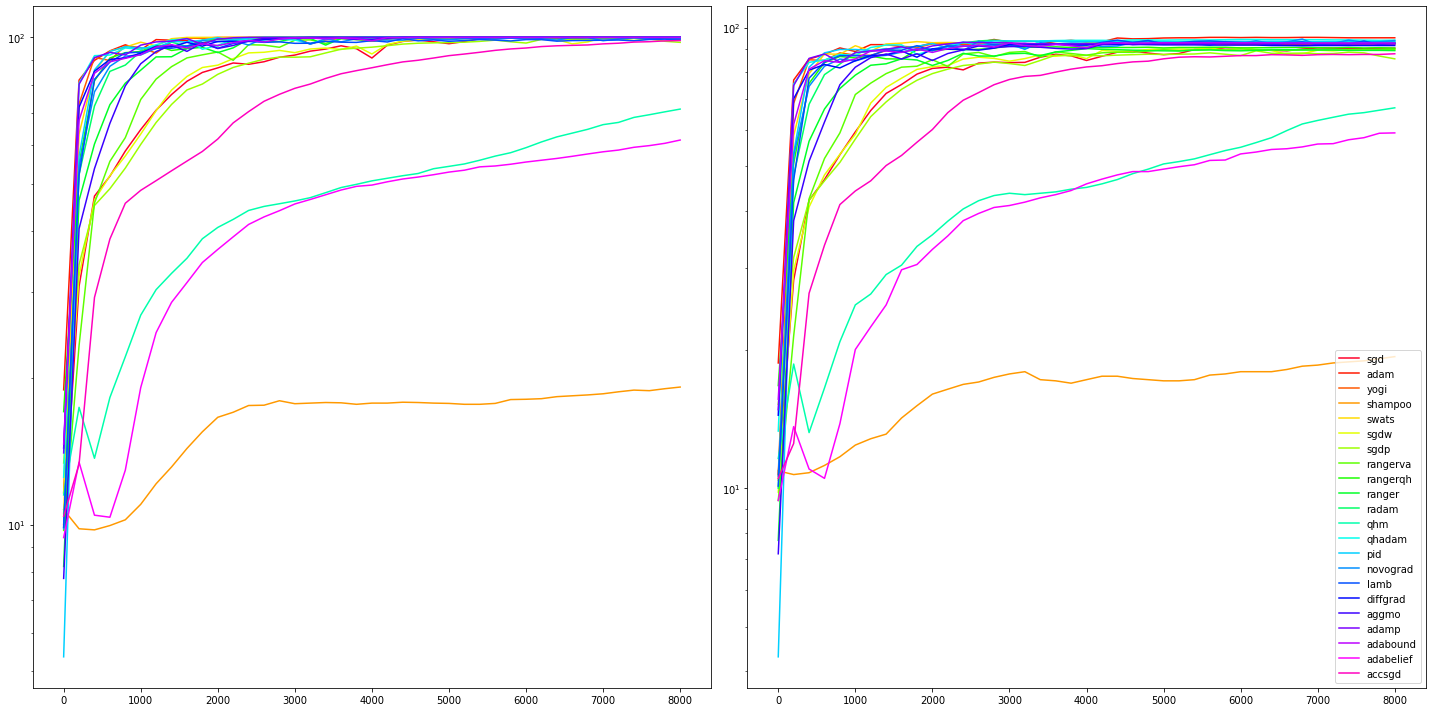

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

num_colors = len(all_results)

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=num_colors-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
axs[0].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(num_colors)])
axs[1].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(num_colors)])

# train
t = range(0, total_steps+1, eval_every)
for solver in all_results.keys():
    axs[0].plot(t, all_results[solver]["train_acc"], label=solver)
    axs[0].set_yscale('log')
t = range(0, total_steps+1, eval_every)
for solver in all_results.keys():
    axs[1].plot(t, all_results[solver]["test_acc"], label=solver)
    axs[1].set_yscale('log')

plt.legend()
plt.tight_layout()

fig.savefig("results_cnn_acc.pdf")

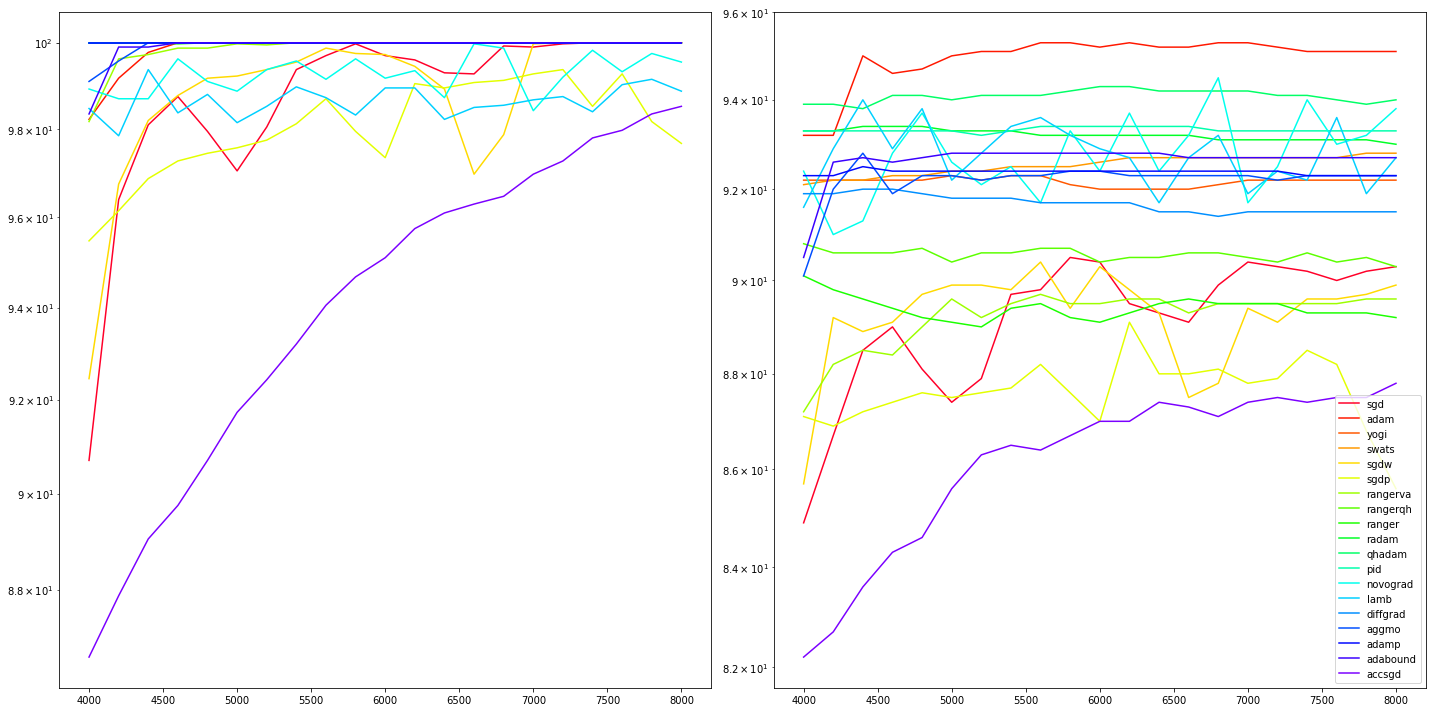

In [17]:
start_from = 20
exclude_solvers = ["shampoo", "adabelief", "qhm"]
#exclude_solvers = ["shampoo"]

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

num_colors = len(all_results)

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=num_colors-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
axs[0].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(num_colors)])
axs[1].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(num_colors)])
#axs[1].set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

# train
t = list(range(0, total_steps+1, eval_every))[start_from:]
for solver in all_results.keys():
    if solver in exclude_solvers:
        continue
    axs[0].plot(t, all_results[solver]["train_acc"][start_from:], label=solver)
    axs[0].set_yscale('log')
t = list(range(0, total_steps+1, eval_every))[start_from:]
for solver in all_results.keys():
    if solver in exclude_solvers:
        continue
    axs[1].plot(t, all_results[solver]["test_acc"][start_from:], label=solver)
    axs[1].set_yscale('log')

plt.legend()
plt.tight_layout()

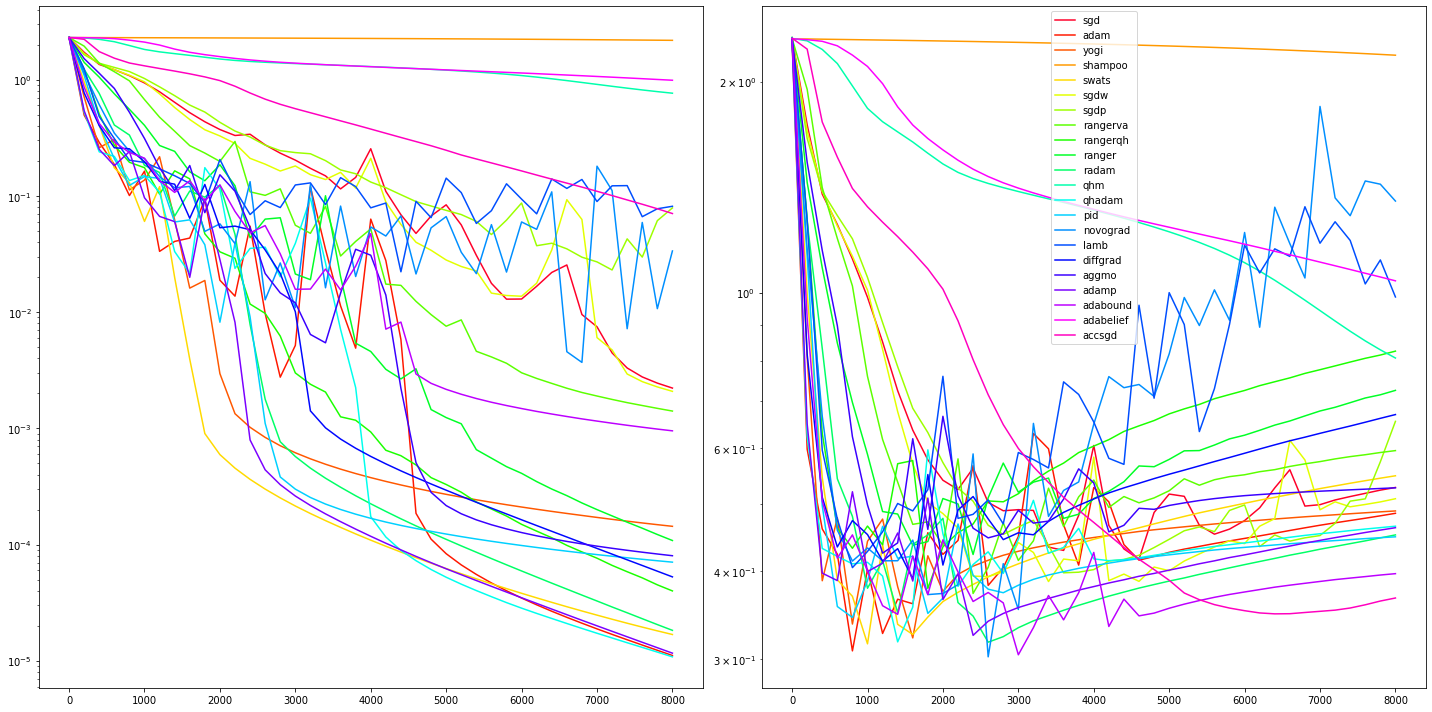

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

num_colors = len(all_results)

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=num_colors-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
axs[0].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(num_colors)])
axs[1].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(num_colors)])

# train
t = range(0, total_steps+1, eval_every)
for solver in all_results.keys():
    axs[0].plot(t, all_results[solver]["train_losses"], label=solver)
    axs[0].set_yscale('log')
for solver in all_results.keys():
    axs[1].plot(t, all_results[solver]["test_losses"], label=solver)
    axs[1].set_yscale('log')

plt.legend()
plt.tight_layout()

fig.savefig("results_cnn_losses.pdf")

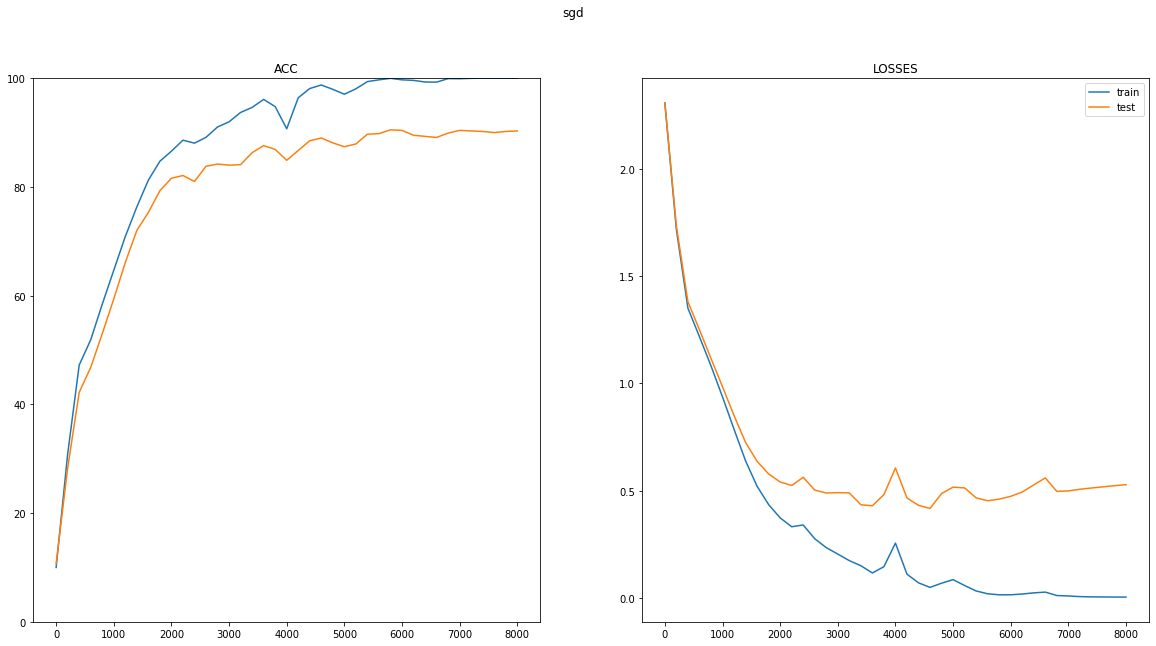

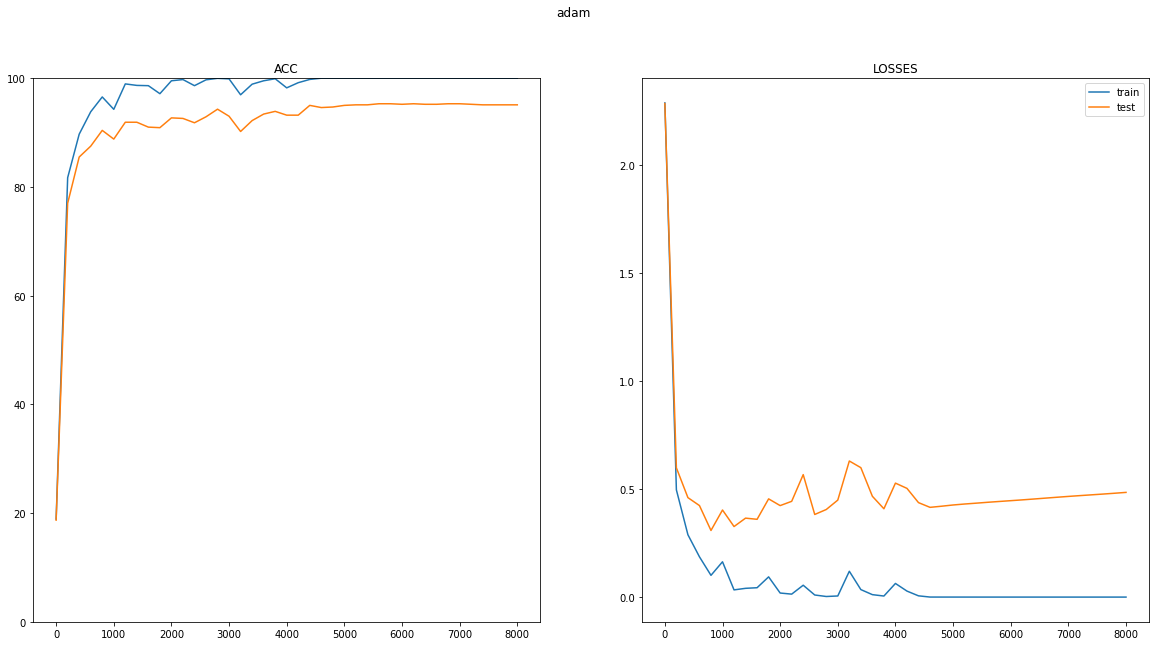

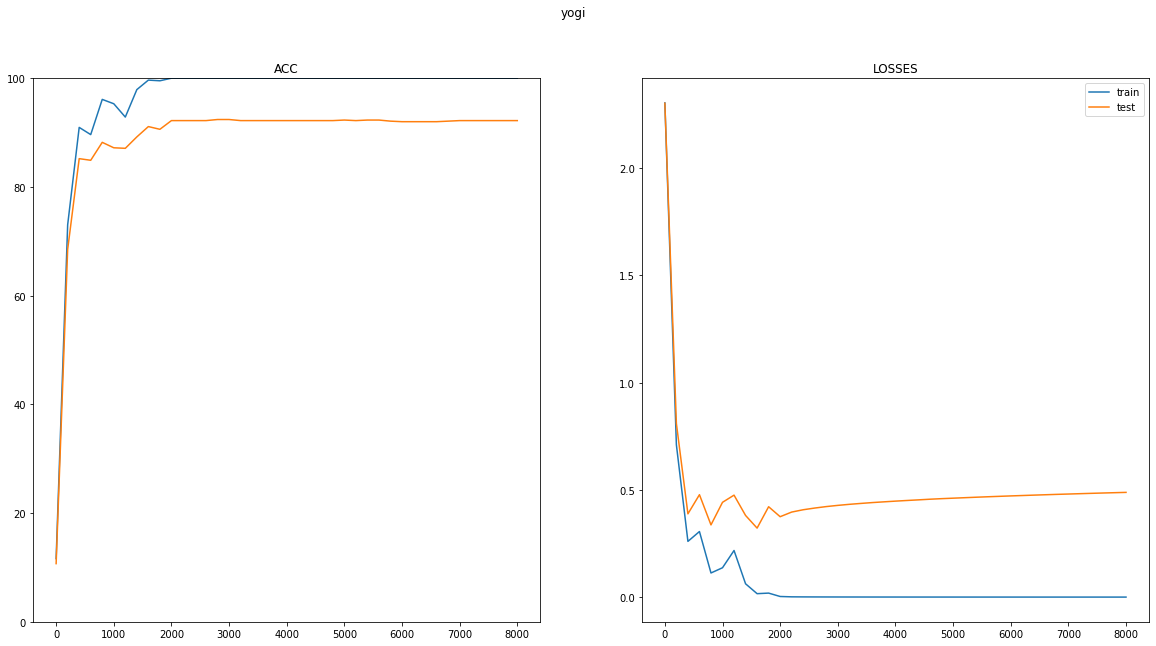

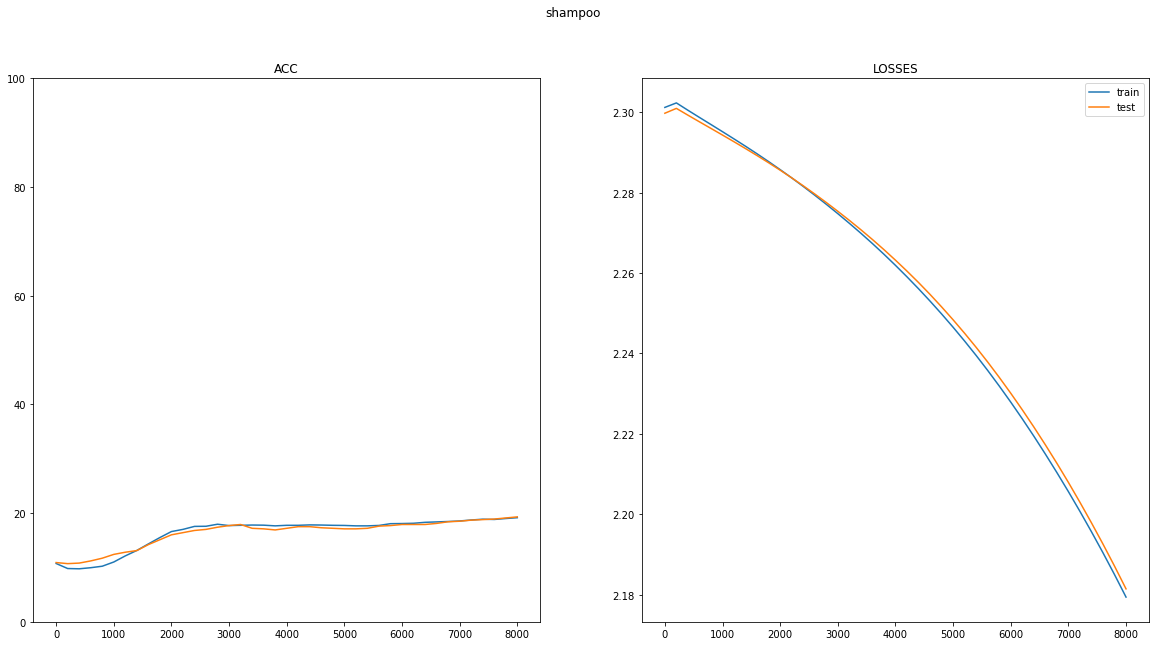

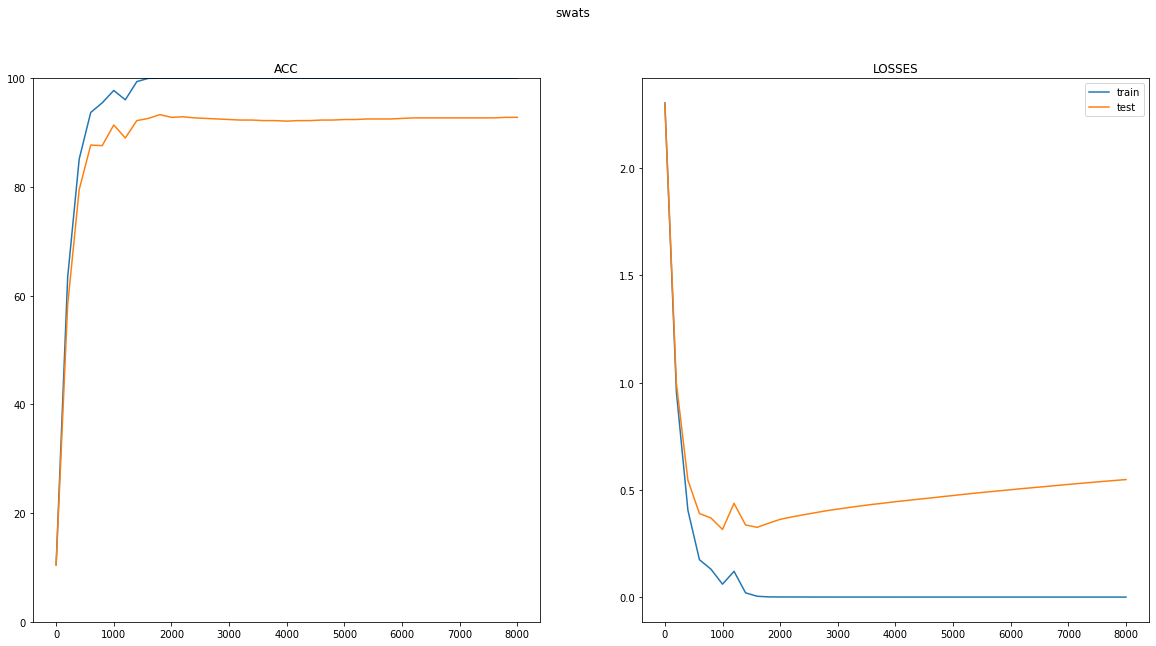

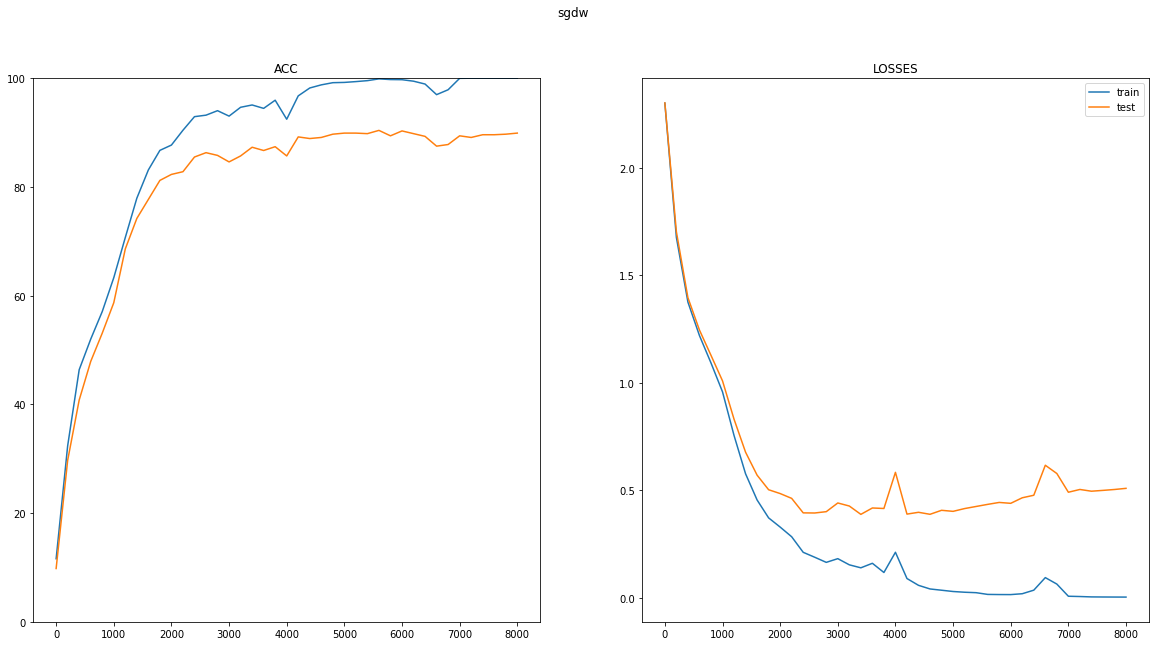

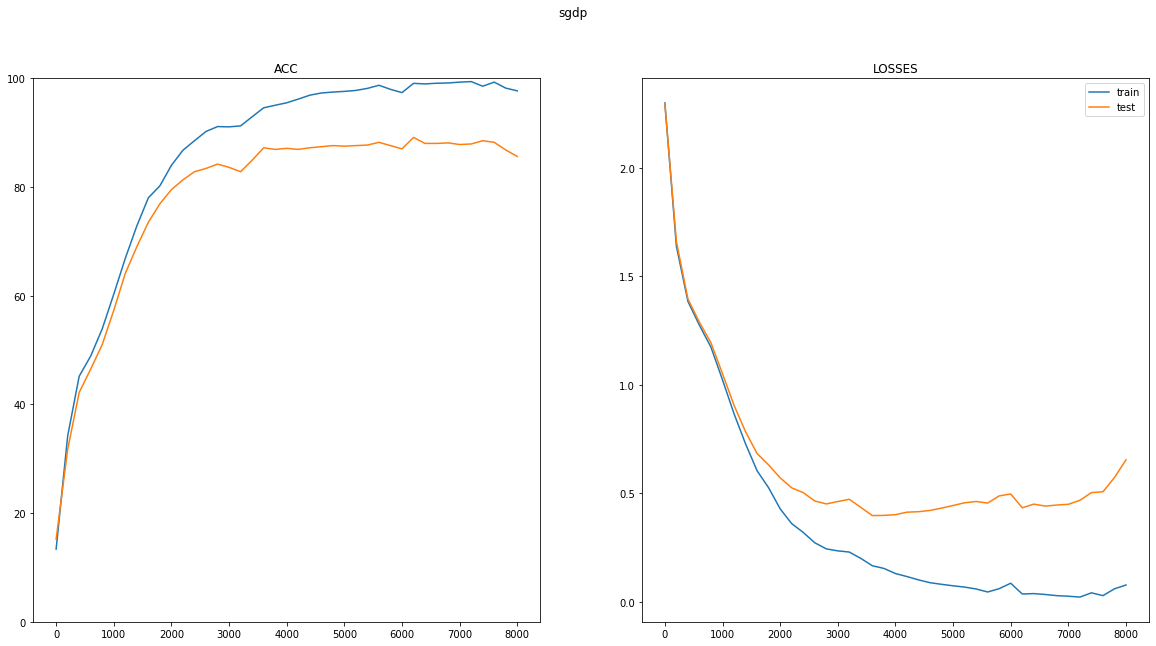

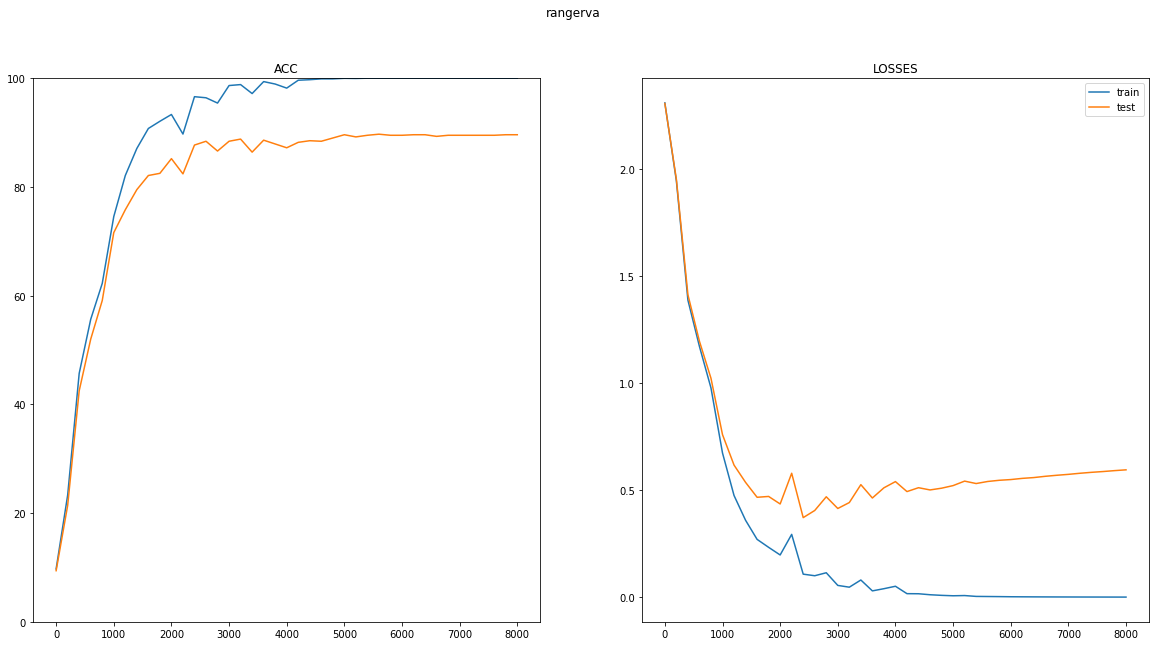

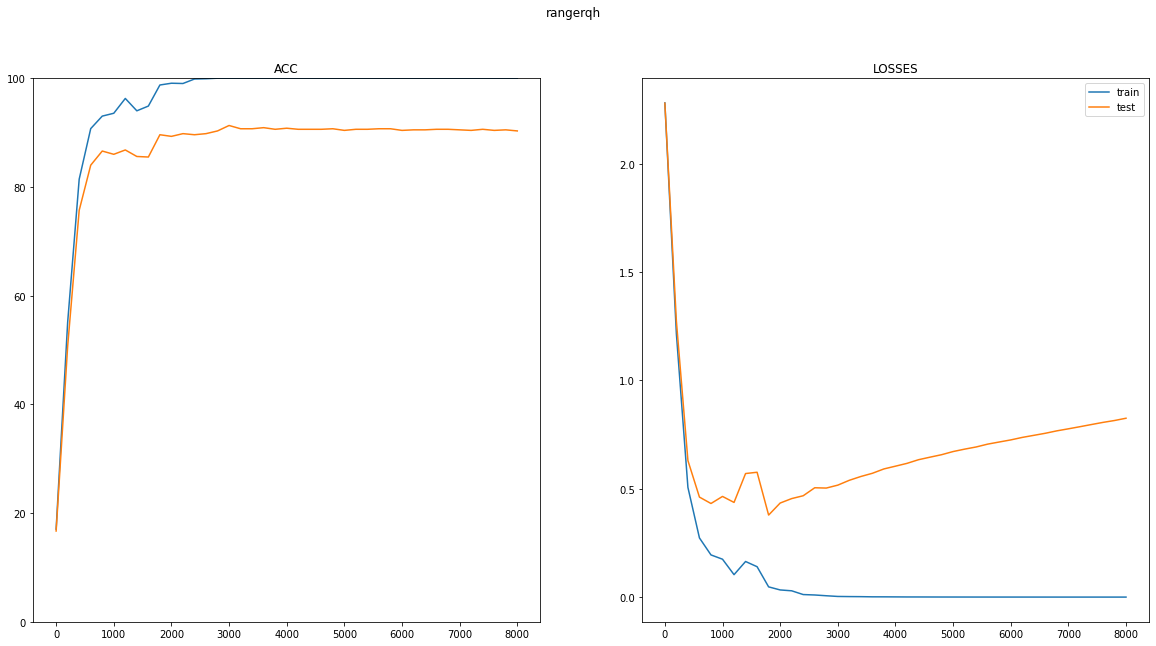

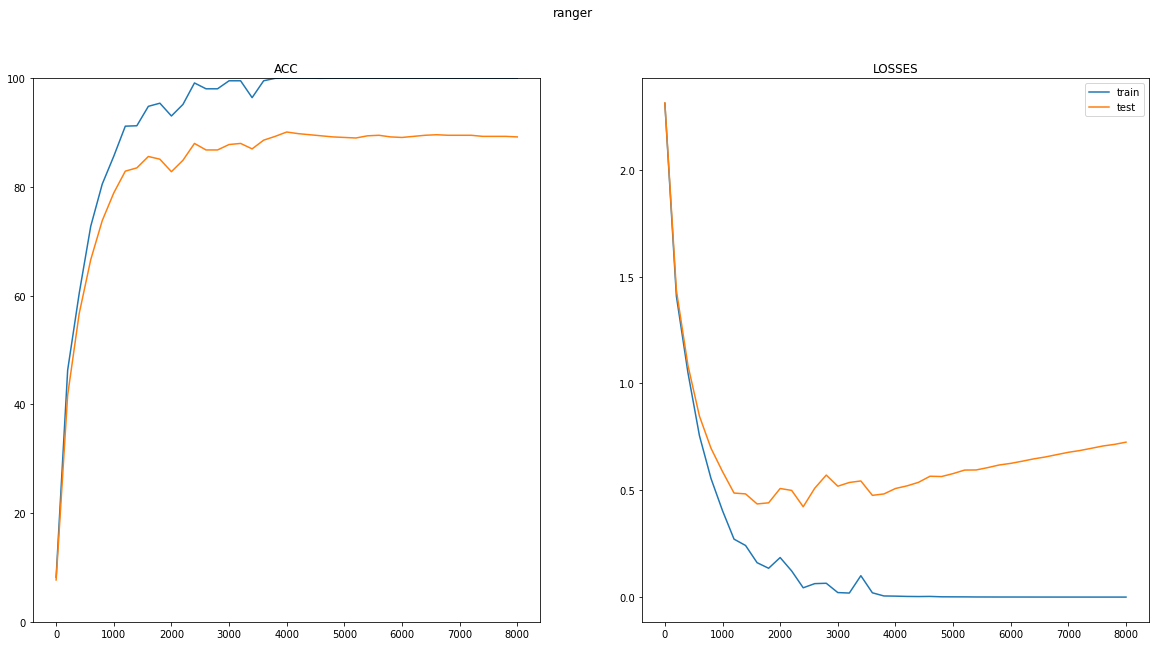

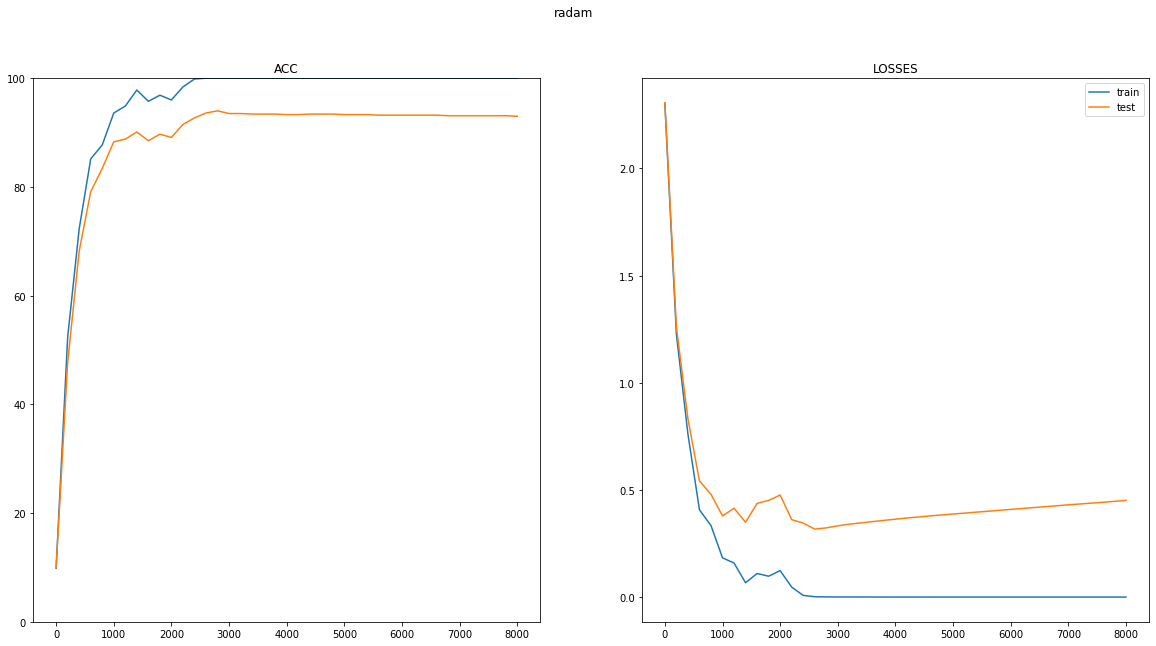

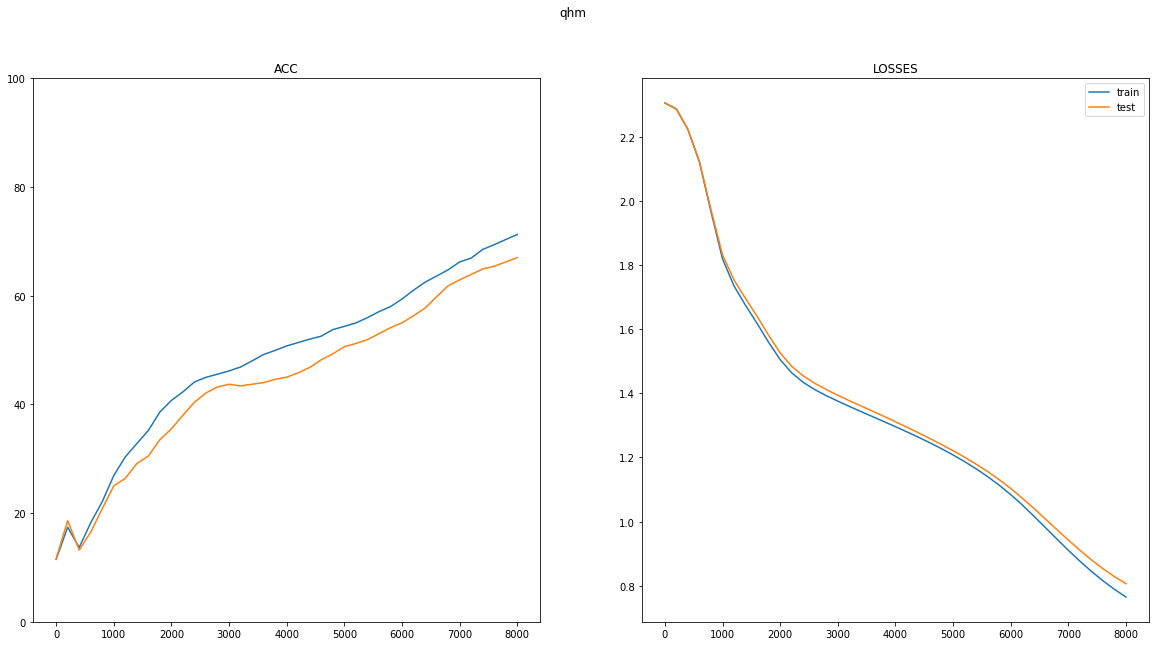

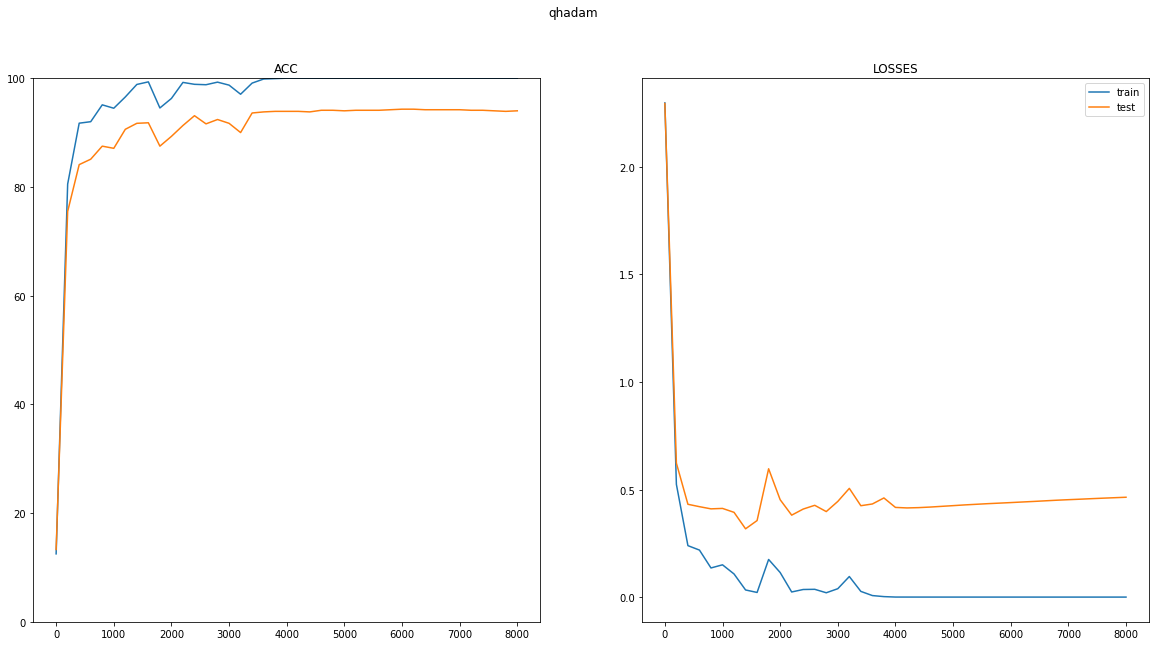

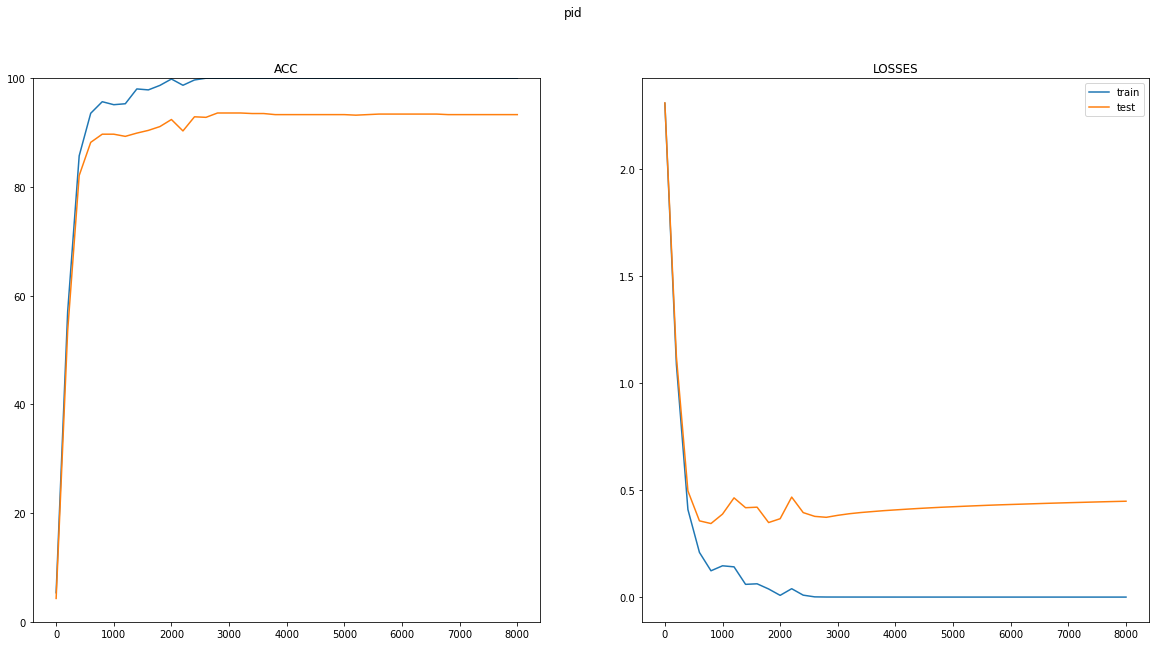

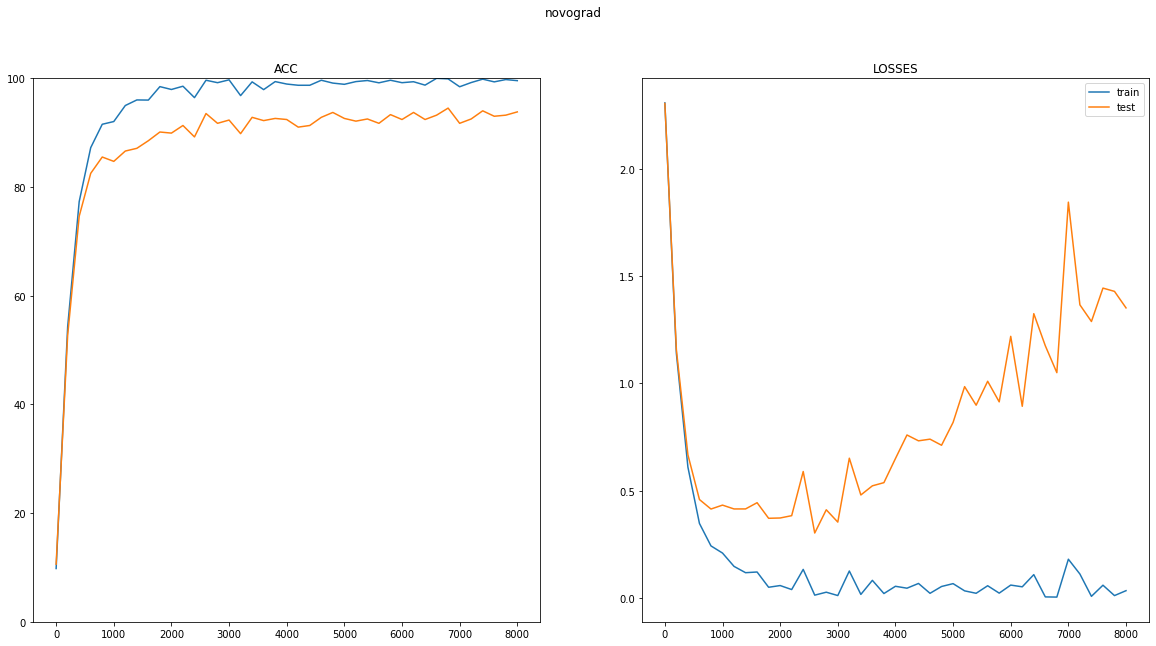

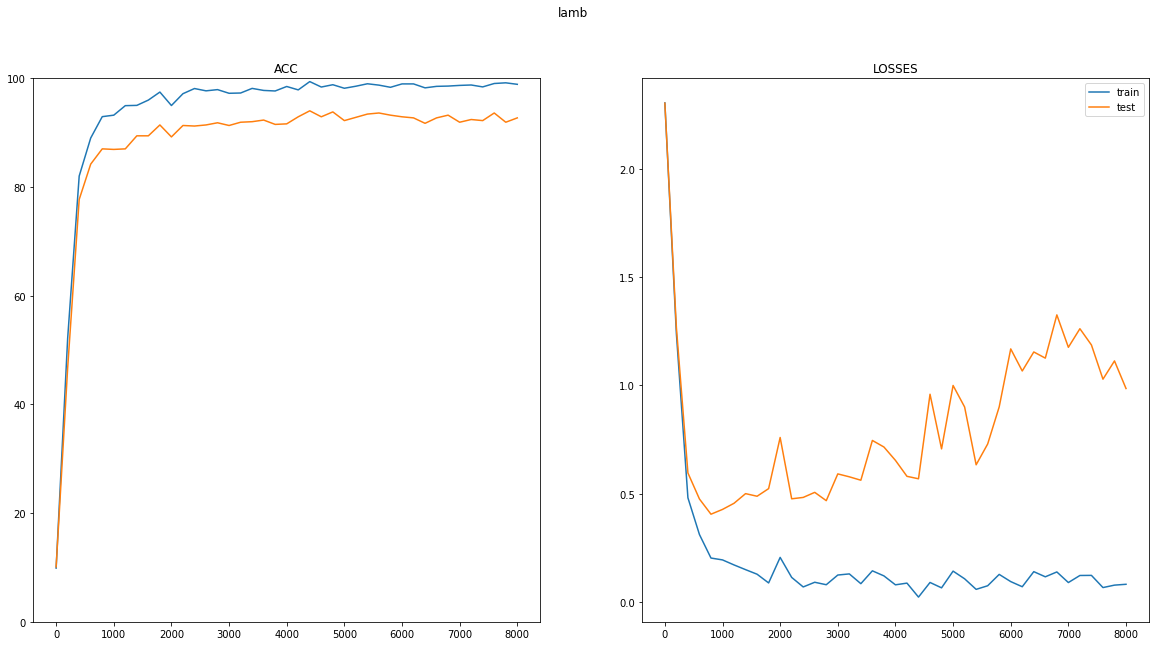

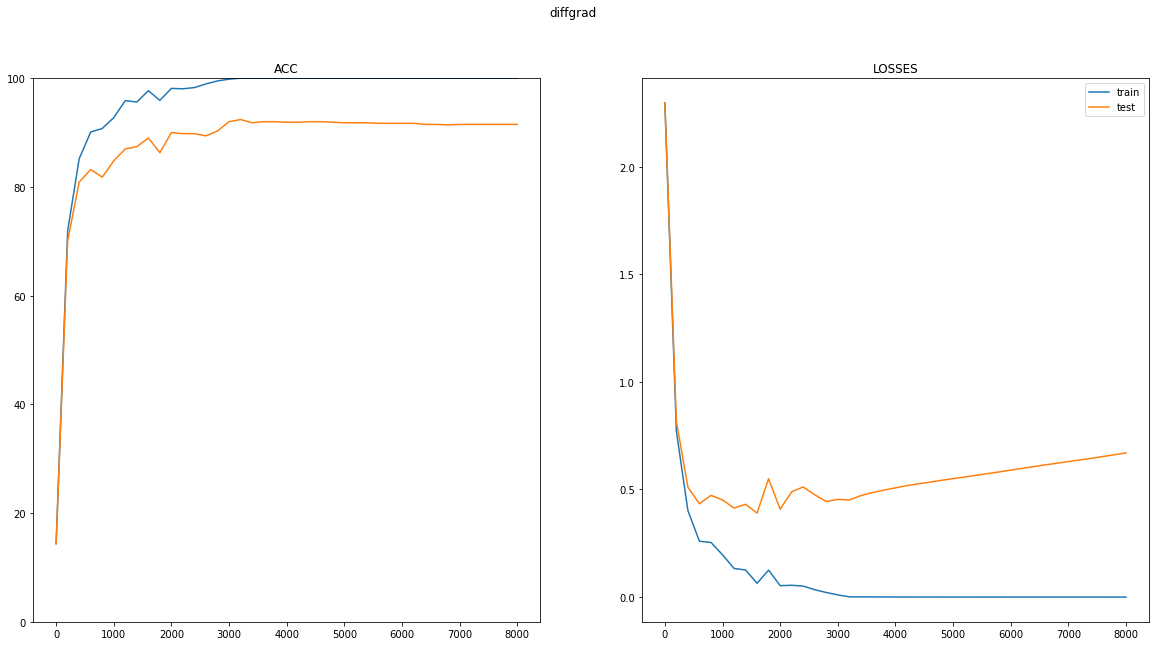

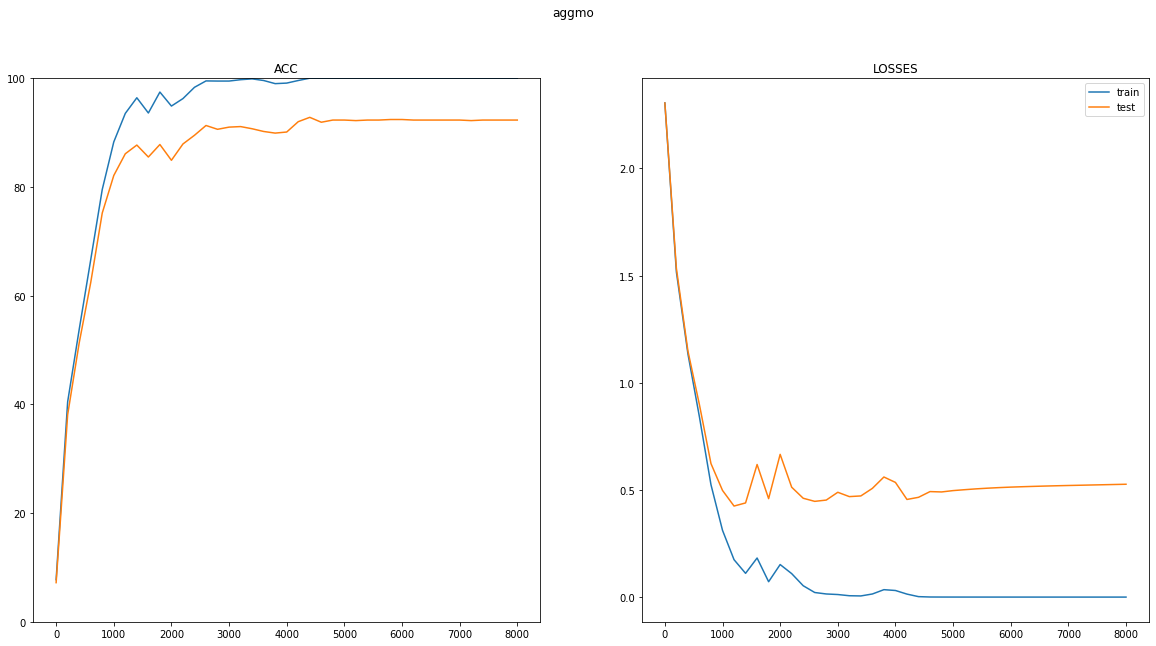

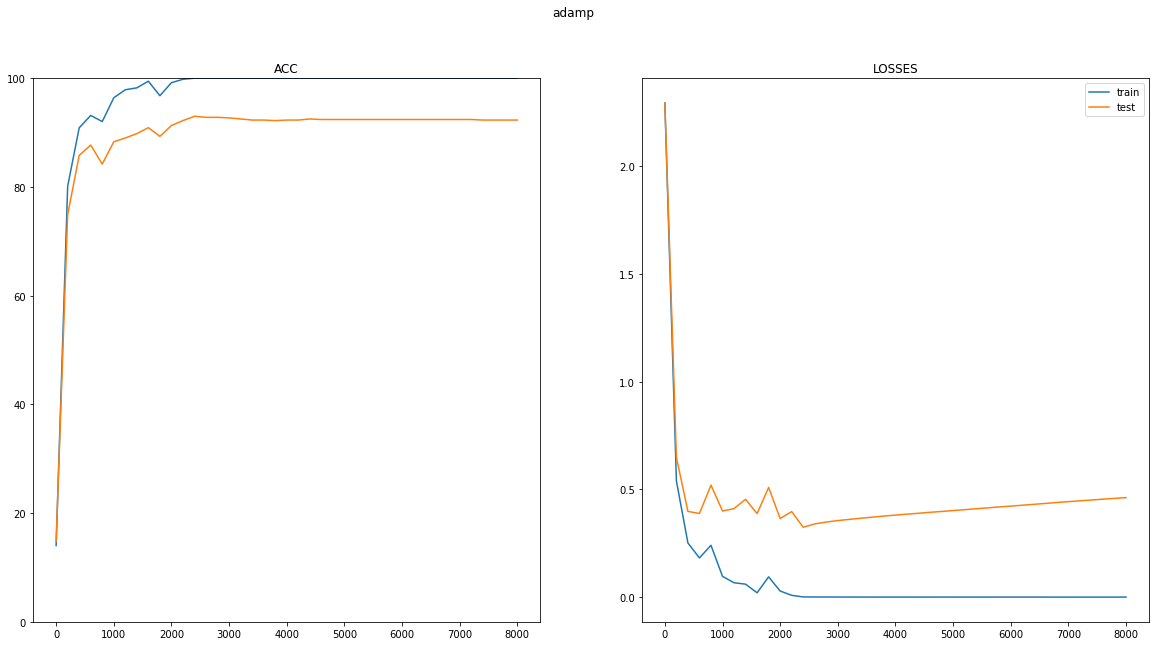

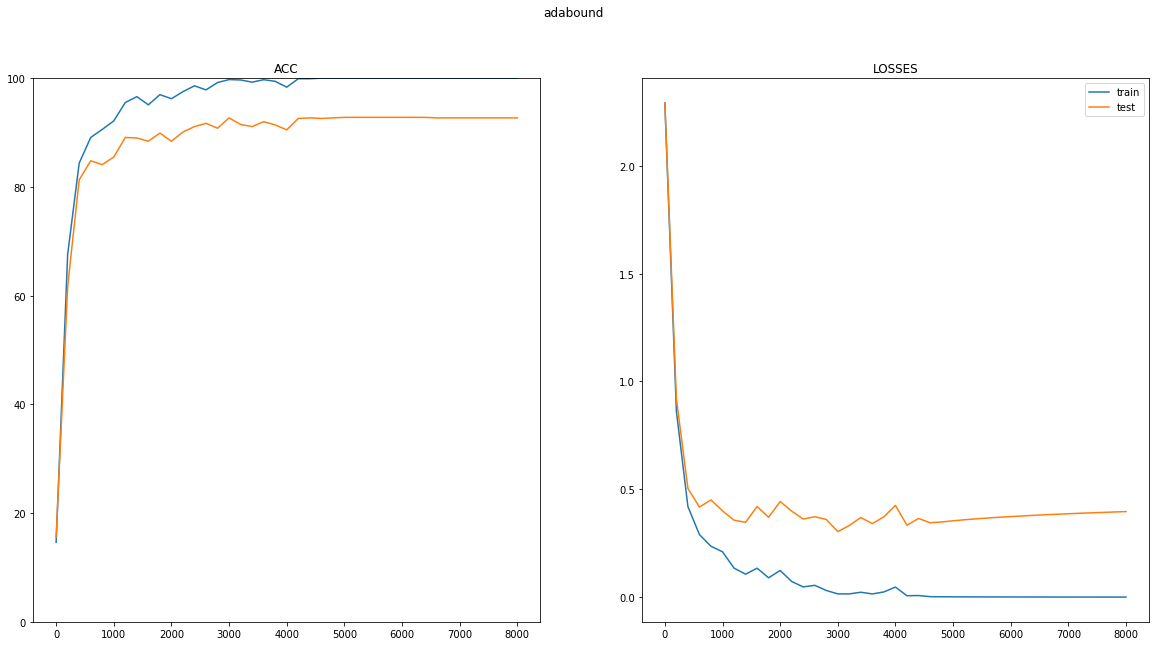

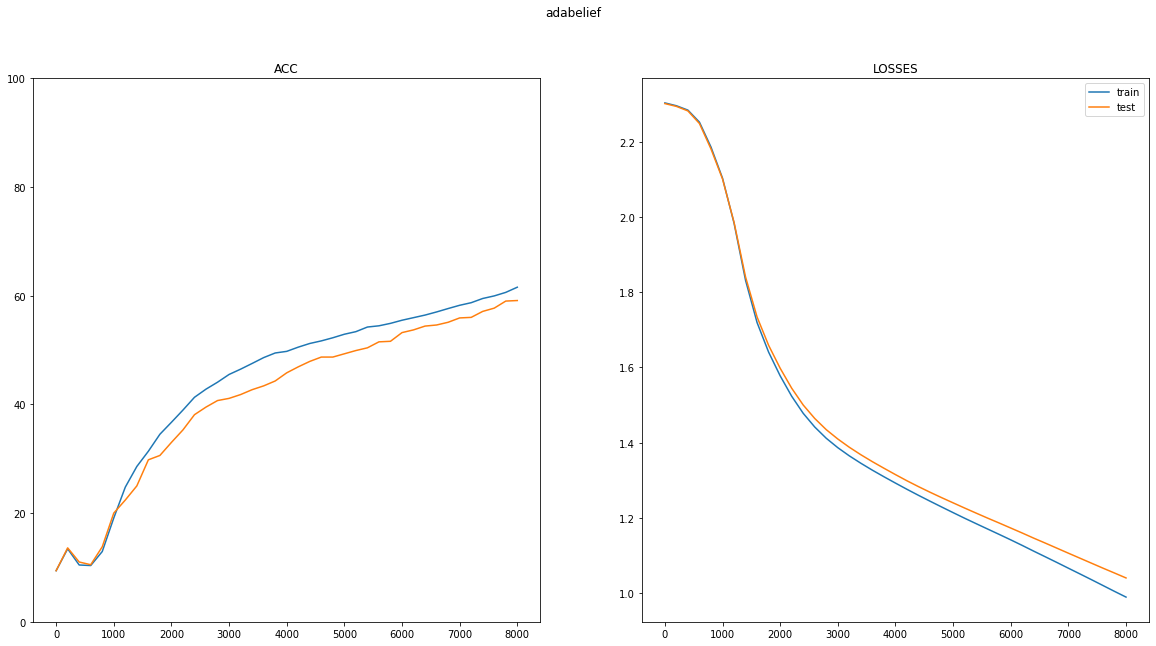

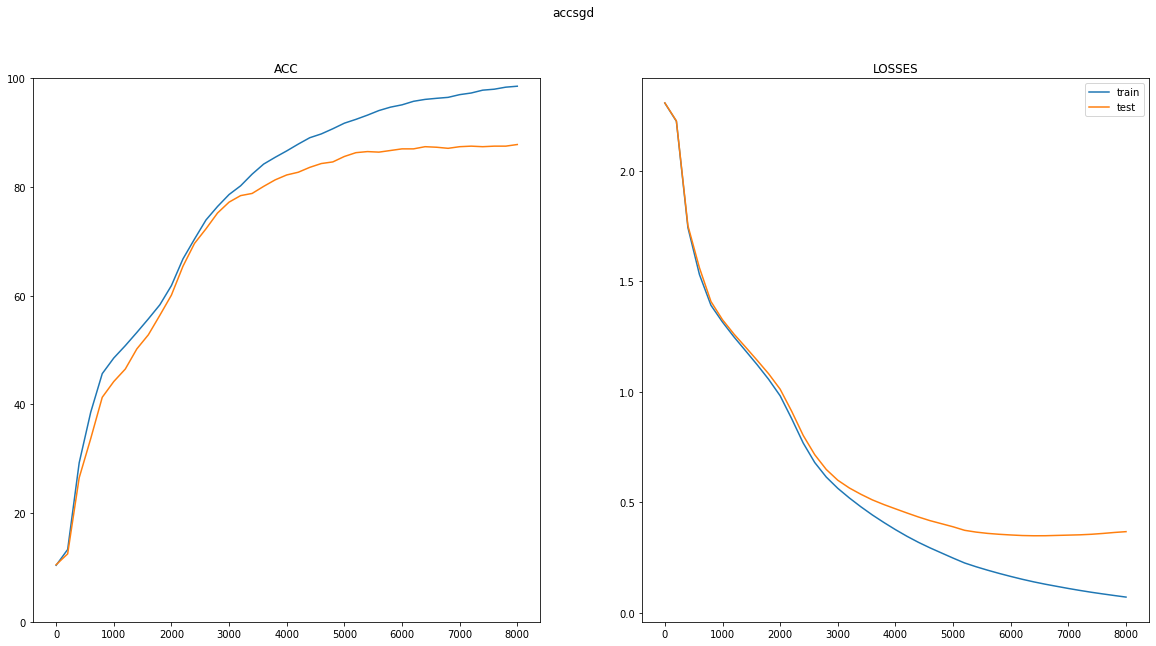

In [30]:
for solver in all_results.keys():
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    t = range(0, total_steps+1, eval_every)
    axs[0].plot(t, all_results[solver]["train_acc"], label="train")
    axs[0].plot(t, all_results[solver]["test_acc"], label="test")
    axs[0].set_title("ACC")
    #axs[0].set_yscale('log')
    axs[0].set_ylim(0, 100)
    
    t = range(0, total_steps+1, eval_every)
    axs[1].plot(t, all_results[solver]["train_losses"], label="train")
    axs[1].plot(t, all_results[solver]["test_losses"], label="test")
    axs[1].set_title("LOSSES")
    #axs[1].set_yscale('log')
    fig.suptitle(solver)
    plt.legend()
    plt.show()